Librerias

In [150]:
import numpy as np
import pandas as pd
import string
import re
import nltk
from nltk import pos_tag
from nltk.corpus import stopwords
from nltk.corpus import wordnet
from nltk.stem import WordNetLemmatizer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.feature_selection import VarianceThreshold
from scipy.spatial.distance import cosine
from unidecode import unidecode
from sklearn.tree import plot_tree
from sklearn.feature_selection import RFE
from sklearn.datasets import make_classification

# Gráficos
import matplotlib.pyplot as plt
import matplotlib.style as style
import seaborn as sns
from wordcloud import WordCloud

# Preprocesado y modelado
from sklearn import svm
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import confusion_matrix
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.metrics import accuracy_score
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.datasets import make_classification
from sklearn.metrics import classification_report
from sklearn.model_selection import cross_val_score

# Configuración warnings
import warnings
warnings.filterwarnings('ignore')
import nltk
nltk.download('stopwords')
nltk.download('averaged_perceptron_tagger')
nltk.download('wordnet')

import warnings

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\jose\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     C:\Users\jose\AppData\Roaming\nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\jose\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


Cargando el datasets

In [151]:
# Ruta del archivo Txt
df = pd.read_csv("train_new.txt", delimiter = '|') 
  
# Guardamos el dataframe en un archivo Csv
df.to_csv('hola.csv',  index = None) 

# Imprimimos los datos para comprobar
print(df.head())

  idioma                                              texto
0     en  host with After to rugby test World system, th...
1     en  and Africa in permission winners,[25] of in ye...
2     en  President tournament wearing presenting were m...
3     en  The the are 'The thirty-eight reference as Ell...
4     en  a The Rugby In and Warrant head 'The Webb and ...


Mostrar en columnas

In [152]:
df[['idioma','texto']].head()

,idioma,texto
0,en,"host with After to rugby test World system, th..."
1,en,"and Africa in permission winners,[25] of in ye..."
2,en,President tournament wearing presenting were m...
3,en,The the are 'The thirty-eight reference as Ell...
4,en,a The Rugby In and Warrant head 'The Webb and ...


Se cuentan el numero total de filas en el archivo

In [153]:
# Contar el total de filas
total_filas = df.shape[0]

print("Total de filas:", total_filas)

Total de filas: 1069


Graficamos la distribucion de los datos que tenemos en las 2 categorias (en y nl)

Podemos ver que los datos estan casi perfectamente balanceados

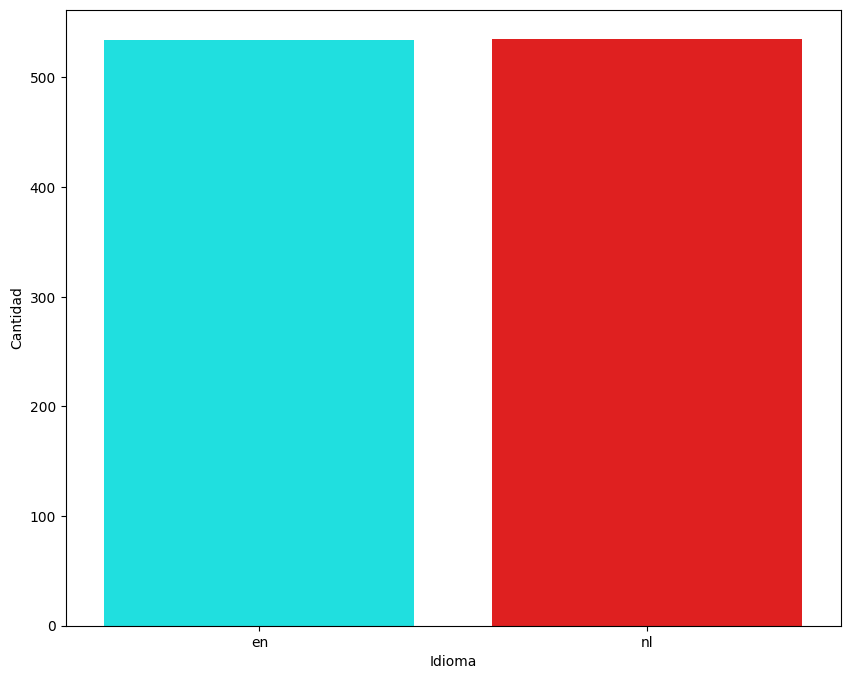

        texto
idioma       
en        534
nl        535


In [154]:
# Establecer el tamaño de la figura
plt.figure(figsize=(10, 8))

# Crear un countplot con las categorías "en" y "nl" de diferentes colores
sns.countplot(data=df, x='idioma', palette={'en': 'cyan', 'nl': 'red'})

# Configurar los ejes y etiquetas
plt.xlabel('Idioma')
plt.ylabel('Cantidad')

# Mostrar el gráfico
plt.show()

n_palabras = df.explode(column='idioma').groupby('idioma').count()
print(n_palabras)

In [155]:
def limpiar_tokenizar(texto):
    # Crear instancia del lematizador
    lemmatizer = WordNetLemmatizer()
    
    nuevo_texto = texto.lower()
    # Eliminación de signos de puntuación
    regex = '[\\!\\"\\#\\$\\%\\&\\(\\)\\*\\+\\,\\-\\.\\/\\:\\;\\<\\=\\>\\?\\@\\[\\\\\\]\\^_\\`\\{\\|\\}\\~]'
    nuevo_texto = re.sub(regex , ' ', nuevo_texto)
    # Eliminación de números
    nuevo_texto = re.sub("\d+", ' ', nuevo_texto)
    # Eliminación de espacios en blanco múltiples
    nuevo_texto = re.sub("\\s+", ' ', nuevo_texto)
    # Eliminación de diéresis
    nuevo_texto = unidecode(nuevo_texto)
    # Eliminación de fracciones
    nuevo_texto = re.sub("\d+/\d+", ' ', nuevo_texto)
    # Eliminación de fechas
    nuevo_texto = re.sub("\d{1,2}/\d{1,2}/\d{2,4}", ' ', nuevo_texto)
    # Tokenización por palabras individuales
    nuevo_texto = nuevo_texto.split(sep=' ')
    # Lematización
    nuevo_texto = [lemmatizer.lemmatize(token) for token in nuevo_texto]

    
    return nuevo_texto

Asignamos estos valores a una nueva columna llamada "texto_tokenizado" y actualizamos el dataFrame

In [156]:
df['texto_tokenizado'] = df['texto'].apply(lambda x: limpiar_tokenizar(x))
df[['idioma','texto','texto_tokenizado']].to_csv('hola.csv', index=False)

Esto convierte nuestro df en uno nuevo llamado "texto_tidy" donde cada token se coloca en una fila y la columna se llama "token"

In [157]:
texto_tidy =df.explode(column='texto_tokenizado')
texto_tidy= texto_tidy.drop(columns='texto')
texto_tidy= texto_tidy.rename(columns={'texto_tokenizado':'token'})
texto_tidy.to_csv('texto_tidy.csv', index=False)

# Imprimimos los datos para comprobar
print(texto_tidy.head(10))

# Imprimimos la cantidad de filas del nuevo df "texto_tidy"
print("\nTotal de filas:", texto_tidy.shape[0])

  idioma      token
0     en       host
0     en       with
0     en      after
0     en         to
0     en      rugby
0     en       test
0     en      world
0     en     system
0     en        the
0     en  australia

Total de filas: 15909


Graficamos una nube de palabras donde se ven las palabras mas consonantes

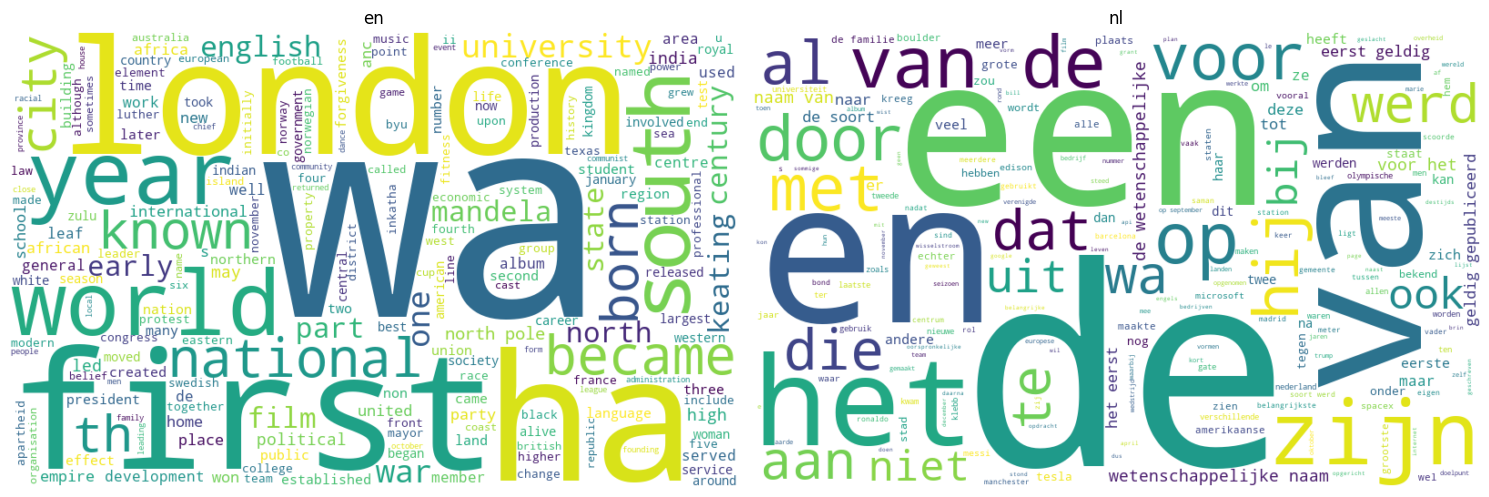

In [158]:
# Convert float items to strings in the palabras list
palabras_por_categoria = texto_tidy.groupby('idioma')['token'].apply(lambda x: [str(word) for word in x])

# Create an instance of WordCloud for each category and generate the word cloud
wordclouds = {}
for categoria, palabras in palabras_por_categoria.items():
    wordcloud = WordCloud(width=800, height=500, background_color='white').generate(' '.join(palabras))
    wordclouds[categoria] = wordcloud

# Display the word clouds for each category
plt.figure(figsize=(15, 10))
for i, (categoria, wordcloud) in enumerate(wordclouds.items()):
    plt.subplot(1, 2, i+1)
    plt.imshow(wordcloud, interpolation='bilinear')
    plt.title(categoria)
    plt.axis('off')
plt.tight_layout()
plt.show()

Graficamos la cantidad de palabras y su distribución 

Como podemos ver siguen una distribucion parecida a la anterior y tambien estan casi perfectamente balanceados

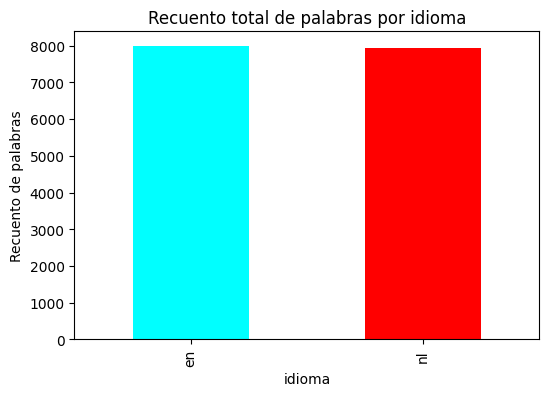


Palabras totales por idioma 

idioma
en    7986
nl    7923
Name: token, dtype: int64


In [159]:
# Recuento total de palabras por categoría
word_count = texto_tidy.groupby('idioma')['token'].count()

# Crear la tabla gráfica
fig, ax = plt.subplots(figsize=(6, 4))
colors = ['cyan', 'red']  # Colores para las categorías 'rotten' y 'fresh'
word_count.plot(kind='bar', ax=ax, color=colors)
ax.set_xlabel('idioma')
ax.set_ylabel('Recuento de palabras')
ax.set_title('Recuento total de palabras por idioma')

# Mostrar la tabla gráfica
plt.show()


print('\nPalabras totales por idioma \n')

texto_tidy.groupby(by='idioma')['token'].count()
print(word_count)

La cantidad de palabras distintas en cada idioma

In [160]:
# Palabras distintas utilizadas 
print('----------------------------')
print('Palabras distintas por idioma')
print('----------------------------')
print(texto_tidy.groupby(by='idioma')['token'].nunique())

----------------------------
Palabras distintas por idioma
----------------------------
idioma
en    2712
nl    2755
Name: token, dtype: int64


Representamos esto es un grafico circular

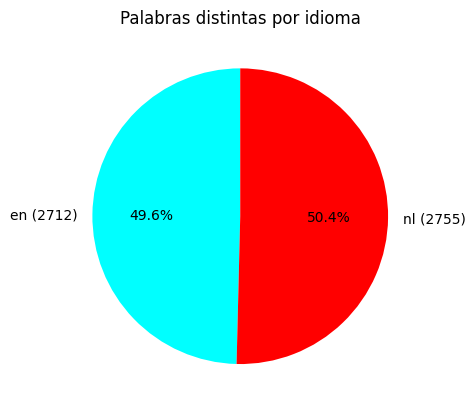

In [161]:
# Gráfico porcentaje de palabras distintas por idioma
unique_words = texto_tidy.groupby('idioma')['token'].nunique()

# Definir los colores de las categorías
colors = ['cyan', 'red']

# Crear el gráfico de pastel
fig, ax = plt.subplots()
patches, texts, autotexts = ax.pie(unique_words, labels=unique_words.index, autopct='%1.1f%%', startangle=90, colors=colors)

# Agregar los valores numéricos junto a las etiquetas
for i, label in enumerate(texts):
    percentage = label.get_text()
    count = unique_words[i]
    label.set_text(f'{percentage} ({count})')

ax.set_title('Palabras distintas por idioma')

# Mostrar el gráfico de pastel
plt.show()


Número de palabras comunes entre los idiomas

In [162]:
palabras_en = set(texto_tidy[texto_tidy.idioma == 'en']['token'])
palabras_nl = set(texto_tidy[texto_tidy.idioma == 'nl']['token'])


print(f"Palabras comunes entre Ingles y Nerlandes: {len(palabras_en.intersection(palabras_nl))}")

Palabras comunes entre Ingles y Nerlandes: 178


Creamos un nuevo df con las palabras comunes y lo llamaremos palabras_comunes

In [163]:
palabras_comunes = palabras_en.intersection(palabras_nl)
palabras_comunes_lista = list(palabras_comunes)

df_palabras_comunes = pd.DataFrame(palabras_comunes_lista, columns=['Palabra'])
df_palabras_comunes.to_csv('palabras_comunes.csv', index=False)

Graficamos una nube de palabras con las palabras comunes entre los 2 idiomas

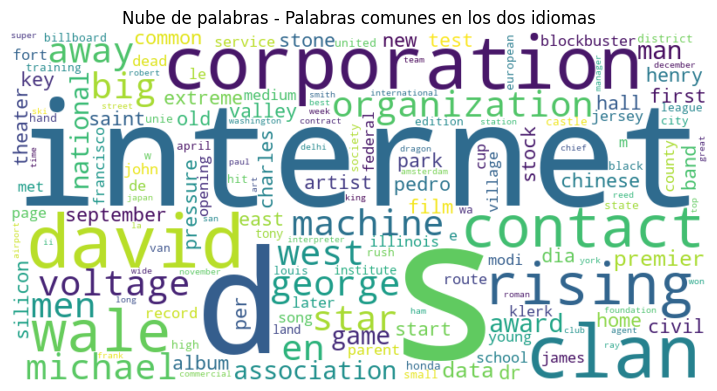

In [164]:
# Nube las palabras comunes en las dos idiomas
# Convertir los elementos de palabras_comunes a cadenas de texto
palabras_comunes_str = [str(palabra) for palabra in palabras_comunes]

# Crear una cadena de texto con las palabras comunes
texto_comun = ' '.join(palabras_comunes_str)

# Crear el objeto WordCloud
wordcloud = WordCloud(width=800, height=400, background_color='white').generate(texto_comun)

# Mostrar la nube de palabras
plt.figure(figsize=(9, 6))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.title('Nube de palabras - Palabras comunes en los dos idiomas')
plt.show()

Calculamos la probabilidad de que una palabra aparezca en un idioma, un ratio negativo negativo indica que es mas frecuente su aparicion en "nl" y uno positivo que es mas frecuente en "en"

In [165]:
# Cálculo del log of odds ratio de cada palabra (rotten vs fresh)
# ==============================================================================
# Pivotaje y despivotaje
comentarios_pivot = texto_tidy.groupby(["idioma","token"])["token"] \
                .agg(["count"]).reset_index() \
                .pivot(index = "token" , columns="idioma", values= "count")

comentarios_pivot = comentarios_pivot.fillna(value=0)
comentarios_pivot.columns.name = None

comentarios_unpivot = comentarios_pivot.melt(value_name='n', var_name='idioma', ignore_index=False)
comentarios_unpivot = comentarios_unpivot.reset_index()

# Selección de las categorias rotten y fresh
comentarios_unpivot = comentarios_unpivot[comentarios_unpivot.idioma.isin(['en', 'nl'])]

# Se añade el total de palabras de cada categoria
comentarios_unpivot = comentarios_unpivot.merge(
                    texto_tidy.groupby('idioma')['token'].count().rename('N'),
                    how = 'left',
                    on  = 'idioma'
                 )

# Cálculo de odds y log of odds de cada palabra
comentarios_logOdds = comentarios_unpivot.copy()
comentarios_logOdds['odds'] = (comentarios_logOdds.n + 1) / (comentarios_logOdds.N + 1)
comentarios_logOdds = comentarios_logOdds[['token', 'idioma', 'odds']] \
                    .pivot(index='token', columns='idioma', values='odds')
comentarios_logOdds.columns.name = None

comentarios_logOdds['log_odds']     = np.log(comentarios_logOdds.en/comentarios_logOdds.nl)
comentarios_logOdds['abs_log_odds'] = np.abs(comentarios_logOdds.log_odds)

# Si el logaritmo de odds es mayor que cero, significa que es una palabra con
# mayor probabilidad de ser de rotten. Esto es así porque el ratio se ha
# calculado como rotten/fresh.
comentarios_logOdds['categoria frecuente'] = np.where(comentarios_logOdds.log_odds > 0,
                                              "en",
                                              "nl"
                                    )

print('-----------------------------------')
print('Top 10 palabras más diferenciadoras')
print('-----------------------------------')
comentarios_logOdds.sort_values('abs_log_odds', ascending=False).head(15)

-----------------------------------
Top 10 palabras más diferenciadoras
-----------------------------------


,en,nl,log_odds,abs_log_odds,categoria frecuente
token,,,,,
het,0.000125,0.030414,-5.492716,5.492716,nl
een,0.000125,0.028016,-5.410596,5.410596,nl
van,0.000250,0.038869,-5.044872,5.044872,nl
to,0.017403,0.000126,4.926555,4.926555,en
voor,0.000125,0.012998,-4.642648,4.642648,nl
en,0.000250,0.025745,-4.632892,4.632892,nl
op,0.000125,0.011989,-4.561796,4.561796,nl
zijn,0.000125,0.011610,-4.529708,4.529708,nl
and,0.032929,0.000379,4.465623,4.465623,en


Graficamos los log_ods

Text(0.5, 0, 'log odds ratio (en / nl)')

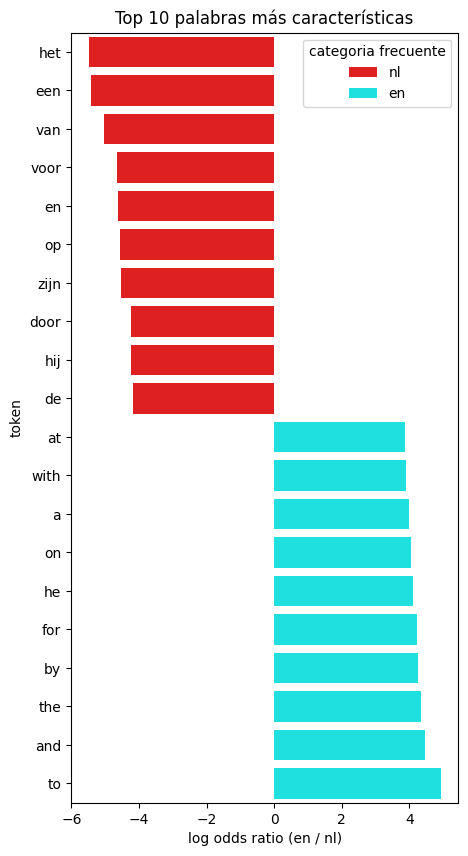

In [166]:
# Top 15 palabras más características de cada categoria


top_30 = comentarios_logOdds[['log_odds', 'abs_log_odds', 'categoria frecuente']] \
        .groupby('categoria frecuente') \
        .apply(lambda x: x.nlargest(10, columns='abs_log_odds').reset_index()) \
        .reset_index(drop=True) \
        .sort_values('log_odds')

f, ax = plt.subplots(figsize=(5, 10))
sns.barplot(
    x='log_odds',
    y='token',
    hue='categoria frecuente',
    data=top_30,
    ax=ax,
    palette={'en': 'cyan', 'nl': 'red'} 
)
ax.set_title('Top 10 palabras más características')
ax.set_xlabel('log odds ratio (en / nl)')

Frecuencia relativa de cada termino

In [167]:
# Cálculo term-frecuency (tf)

tf = texto_tidy.copy()
# Número de veces que aparece cada término en cada texto
tf = tf.groupby(["token"])["token"].agg(["count"]).reset_index()
# Se añade una columna con el total de términos por texto
tf['total_count'] = tf.groupby('token')['count'].transform(sum)
# Se calcula el tf
tf['tf'] = tf["count"] / tf["total_count"]
print("=======================")
tf.sort_values(by = "tf").head(10)

,token,count,total_count,tf
0,,134,134,1.0
3528,place,9,9,1.0
3527,plaatsvinden,1,1,1.0
3526,plaatsnaamtoevoeging,1,1,1.0
3525,plaatselijke,1,1,1.0
3524,plaats,10,10,1.0
3523,pizzabodems,1,1,1.0
3522,pizza's,1,1,1.0
3529,plagplekken,1,1,1.0
3521,pittsburgh,1,1,1.0


Inverso

In [168]:
# Inverse document frequency
# ==============================================================================
idf = texto_tidy.copy()
total_documents = idf["token"].drop_duplicates().count()
# Número de comentarios en los que aparece cada término
idf = idf.groupby(["token"])["token"].agg(["count"]).reset_index()
idf[' n_veces'] = idf.groupby('token')['count'].transform(sum)
# Cálculo del idf
idf['idf'] = np.log(total_documents / idf[' n_veces'])
idf = idf[["token"," n_veces", "idf"]].drop_duplicates()
idf.sort_values(by="idf").head()


,token,n_veces,idf
4533,the,621,2.142053
1093,de,597,2.181467
2194,in,506,2.346848
3212,of,313,2.827181
4777,van,308,2.843285


Creación de la matriz tf-idf

In [169]:
# Term Frequency - Inverse Document Frequency
tf_idf = pd.merge(left=tf, right=idf, on="token")
tf_idf["tf_idf"] = tf_idf["tf"] * tf_idf["idf"]

tf_idf.sort_values(by="token").head()

,token,count,total_count,tf,n_veces,idf,tf_idf
0,,134,134,1.0,134,3.675545,3.675545
1,"""commons""",1,1,1.0,1,8.573384,8.573384
2,"""permission",2,2,1.0,2,7.880237,7.880237
3,'boerenhemd',1,1,1.0,1,8.573384,8.573384
4,'juve',1,1,1.0,1,8.573384,8.573384


Dividimos el conjunto de datos en pruba y entrenamiento

In [170]:
# Leer el archivo CSV
df = pd.read_csv("./hola.csv")

# Acceder a los datos de las columnas
idioma = df['idioma']
texto = df['texto']
texto_tokenizado = df['texto_tokenizado']

df.head()


,idioma,texto,texto_tokenizado
0,en,"host with After to rugby test World system, th...","['host', 'with', 'after', 'to', 'rugby', 'test..."
1,en,"and Africa in permission winners,[25] of in ye...","['and', 'africa', 'in', 'permission', 'winner'..."
2,en,President tournament wearing presenting were m...,"['president', 'tournament', 'wearing', 'presen..."
3,en,The the are 'The thirty-eight reference as Ell...,"['the', 'the', 'are', ""'the"", 'thirty', 'eight..."
4,en,a The Rugby In and Warrant head 'The Webb and ...,"['a', 'the', 'rugby', 'in', 'and', 'warrant', ..."


In [236]:
datos_X = df['texto_tokenizado']
datos_y = df['idioma']

print(datos_X.unique()) 
print("\n\n")
print(datos_y.unique())

X_train, X_test, y_train, y_test = train_test_split(
    datos_X,
    datos_y,
    test_size=0.30
)


["['host', 'with', 'after', 'to', 'rugby', 'test', 'world', 'system', 'the', 'australia', 'zealand', 'jersey', 'national', 'return']"
 "['and', 'africa', 'in', 'permission', 'winner', 'of', 'in', 'year', 'to', 'south', 'after', 'match', 'of', 'test', 'a']"
 "['president', 'tournament', 'wearing', 'presenting', 'were', 'met', 'africa', 'series', 'b', 'the', 'resumption', 'a', 'rugby', 'the', 'opening', 'match', '']"
 ...
 "['', 'uiteindelijk', 'te', 'in', 'tot', 'individuele', 'zomerspelen', 'al', 'maar', 'beste', 'olympische', 'degen', 'koos', 'spelen', 'een']"
 "['degen', 'van', 'olympische', 'en', 'deze', 'van', 'schermen', 'de', 'zilveren', 'sportieve', 'olympische', 'zou', 'individuele', 'uitzondering', 'zijn']"
 "['alle', 'het', 'roeier', 'op', 'zomerspelen', 'zijn', 'berlijn', 'edities', 'in', 'het', 'zowel', 'van', 'uiteindelijk']"]



['en' 'nl']


Vectorizacion de los datos

In [237]:
# Crear una instancia del vectorizador
vectorizer = CountVectorizer()

# Ajustar el vectorizador con los datos de entrenamiento
Xtrain = vectorizer.fit_transform(X_train)

# Transformar los datos de prueba utilizando el vectorizador ajustado
Xtest = vectorizer.transform(X_test)

print("=======================")
print(Xtrain.shape)

(748, 4045)


In [238]:
tokens = vectorizer.get_feature_names_out()
print("=======================")
print("Tokens:", tokens)
print("Tokens:", len(tokens))

Tokens: ['aa' 'aabel' 'aan' ... 'zwelethini' 'zwitserse' 'zynga']
Tokens: 4045


In [239]:
print("Conjunto de entrenamiento - Características:", Xtrain.shape)
print("Conjunto de entrenamiento - Etiquetas:", y_train.shape)
print("Conjunto de prueba - Características:", Xtest.shape)
print("Conjunto de prueba - Etiquetas:", y_test.shape)

Conjunto de entrenamiento - Características: (748, 4045)
Conjunto de entrenamiento - Etiquetas: (748,)
Conjunto de prueba - Características: (321, 4045)
Conjunto de prueba - Etiquetas: (321,)


Funcion de selección de características 

In [240]:
def cuasiConstantes(Xtrain, Xtest, threshold=0.02):
    # Crear el objeto VarianceThreshold
    selector = VarianceThreshold(threshold=threshold)

    # Aplicar la eliminación de características cuasi-constantes en la matriz tf-idf de entrenamiento
    xtrain = selector.fit_transform(Xtrain)

    # Obtener los índices de las características seleccionadas
    selected_feature_indices = selector.get_support(indices=True)

    # Filtrar la matriz tf-idf de prueba utilizando los índices de características seleccionadas
    xtest = selector.transform(Xtest)

    num_selected_features = xtrain.shape[1]
    print("=======================")
    print("Número de características seleccionadas:", num_selected_features)
    print("=======================")
    return xtrain, xtest, selected_feature_indices


def ScaracteristicasRandom(xtrain, y_train, n_estimators=100, max_depth=None, min_samples_split=2):
    # Crear un estimador Random Forest con parámetros ajustados
    rf = RandomForestClassifier(n_estimators=n_estimators, max_depth=max_depth, min_samples_split=min_samples_split, n_jobs=-1)

    # Crear un selector RFE con Random Forest y ranking
    rfe = RFE(estimator=rf, step=2)

    # Aplicar RFE al conjunto de datos
    xtrainE = rfe.fit_transform(xtrain, y_train)
    # Obtener las características seleccionadas
    selected_features = rfe.support_

    # Obtener el ranking de importancia de características
    feature_ranking = rfe.ranking_

    # Imprimir el ranking de características
    print("Ranking de características :")
    for i, rank in enumerate(feature_ranking):
        print(f"Feature {i+1}: {rank}")
    
    # Imprimir las características seleccionadas
    print("\nCaracterísticas seleccionadas:")
    for i, feature in enumerate(selected_features):
        if feature:
            print(f"Feature {i+1}")

    
        


    return xtrainE, selected_features, feature_ranking

In [241]:
xtrain, xtest, selected_feature_indices=cuasiConstantes(Xtrain, Xtest)
#num_selected_features = xtrain.shape[1]

Número de características seleccionadas: 63


In [242]:
xtrainE, selected_features, feature_ranking = ScaracteristicasRandom(xtrain, y_train)
xtestE = xtest[:, selected_features]  # Conjunto de prueba transformado

Ranking de características :
Feature 1: 1
Feature 2: 1
Feature 3: 4
Feature 4: 1
Feature 5: 1
Feature 6: 11
Feature 7: 13
Feature 8: 1
Feature 9: 10
Feature 10: 1
Feature 11: 1
Feature 12: 1
Feature 13: 1
Feature 14: 1
Feature 15: 1
Feature 16: 1
Feature 17: 14
Feature 18: 1
Feature 19: 6
Feature 20: 1
Feature 21: 2
Feature 22: 17
Feature 23: 16
Feature 24: 12
Feature 25: 1
Feature 26: 1
Feature 27: 1
Feature 28: 1
Feature 29: 5
Feature 30: 3
Feature 31: 1
Feature 32: 1
Feature 33: 15
Feature 34: 3
Feature 35: 12
Feature 36: 1
Feature 37: 1
Feature 38: 4
Feature 39: 2
Feature 40: 1
Feature 41: 6
Feature 42: 16
Feature 43: 17
Feature 44: 1
Feature 45: 11
Feature 46: 15
Feature 47: 1
Feature 48: 8
Feature 49: 1
Feature 50: 1
Feature 51: 1
Feature 52: 1
Feature 53: 1
Feature 54: 9
Feature 55: 5
Feature 56: 9
Feature 57: 14
Feature 58: 7
Feature 59: 8
Feature 60: 13
Feature 61: 10
Feature 62: 7
Feature 63: 1

Características seleccionadas:
Feature 1
Feature 2
Feature 4
Feature 5
Feature 8


In [243]:
# Contar características seleccionadas
num_selected_features = sum(selected_features)
print("=======================")
print("Número de características seleccionadas:", num_selected_features)

Número de características seleccionadas: 31


Aprendizaje de maquina

aplicaremos los siguientes modelos de aprendizaje de maquinas:
    -Arboles de decision 
    -Random forest
    -Redes neuronales
    -Redes neuronales profundas

In [244]:
# ARBOLES DE DECISION 

# Ajuste inicial del modelo
dt = DecisionTreeClassifier()
dt.fit(Xtrain, y_train)
y_pred_initial = dt.predict(Xtest)

# Matriz de confusión inicial
dt_initial = confusion_matrix(y_test, y_pred_initial)
dt_df_initial = pd.DataFrame(dt_initial)

# Precisión inicial
from sklearn.metrics import accuracy_score

dt_precision_initial = 100 * accuracy_score(y_test, y_pred_initial)
print('Precisión inicial: {0:.3f}%'.format(dt_precision_initial))

Precisión inicial: 96.573%


In [245]:
# Generate a synthetic classification dataset

y_pred_train = dt.predict(Xtrain)
y_pred_test  = dt.predict(Xtest)

print(classification_report(y_train, y_pred_train))
print('----------------------------------------------------------')
print(classification_report(y_test, y_pred_test))

              precision    recall  f1-score   support

          en       1.00      1.00      1.00       379
          nl       1.00      1.00      1.00       369

    accuracy                           1.00       748
   macro avg       1.00      1.00      1.00       748
weighted avg       1.00      1.00      1.00       748

----------------------------------------------------------
              precision    recall  f1-score   support

          en       0.97      0.96      0.96       155
          nl       0.96      0.97      0.97       166

    accuracy                           0.97       321
   macro avg       0.97      0.97      0.97       321
weighted avg       0.97      0.97      0.97       321



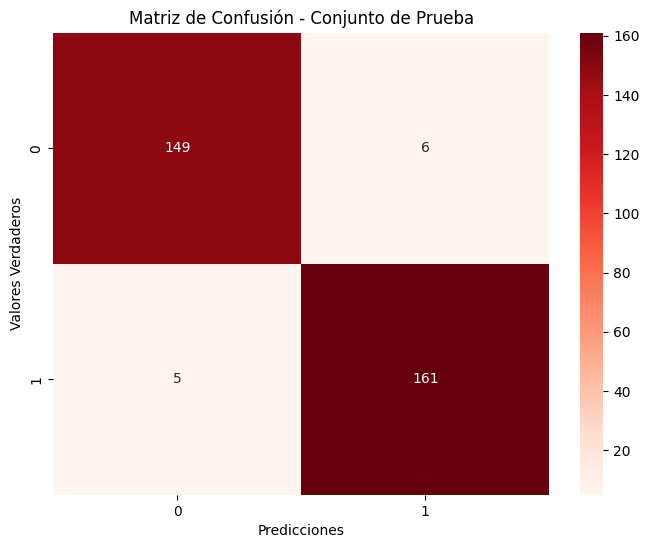

In [246]:
# Crear la matriz de confusión para el conjunto de prueba
cm_test = confusion_matrix(y_test, y_pred_test)

# Crear el mapa de calor para el conjunto de prueba
plt.figure(figsize=(8, 6))
sns.heatmap(cm_test, annot=True, cmap="Reds",fmt='d')
plt.title("Matriz de Confusión - Conjunto de Prueba")
plt.xlabel("Predicciones")
plt.ylabel("Valores Verdaderos")
plt.show()

In [247]:
model = DecisionTreeClassifier(
    criterion='gini',max_depth=10,splitter='best'
)

In [248]:
param_grid = {
    'criterion': ['gini', 'entropy'],
    'min_samples_split': [2, 4, 8, 10, 15],
    'max_depth': [None],
    'min_samples_leaf': [2, 4, 8, 10, 15]
}

grid_model_dt = GridSearchCV(
    estimator=model,
    param_grid = param_grid, 
    error_score="raise",
    refit=True,
    cv=5,
)


In [249]:
grid_model_dt.fit(xtrain, y_train)

GridSearchCV(cv=5, error_score='raise',
             estimator=DecisionTreeClassifier(max_depth=10),
             param_grid={'criterion': ['gini', 'entropy'], 'max_depth': [None],
                         'min_samples_leaf': [2, 4, 8, 10, 15],
                         'min_samples_split': [2, 4, 8, 10, 15]})

In [250]:
grid_model_dt.best_params_

{'criterion': 'entropy',
 'max_depth': None,
 'min_samples_leaf': 2,
 'min_samples_split': 8}

In [251]:
grid_model_dt.best_score_

0.9799552572706934

In [252]:
y_pred_train = grid_model_dt.predict(xtrain)
y_pred_test  = grid_model_dt.predict(xtest)
print(classification_report(y_train, y_pred_train))
print('----------------------------------------------------------')
print(classification_report(y_test, y_pred_test))

              precision    recall  f1-score   support

          en       0.99      1.00      1.00       379
          nl       1.00      0.99      1.00       369

    accuracy                           1.00       748
   macro avg       1.00      1.00      1.00       748
weighted avg       1.00      1.00      1.00       748

----------------------------------------------------------
              precision    recall  f1-score   support

          en       0.96      0.99      0.98       155
          nl       0.99      0.96      0.98       166

    accuracy                           0.98       321
   macro avg       0.98      0.98      0.98       321
weighted avg       0.98      0.98      0.98       321



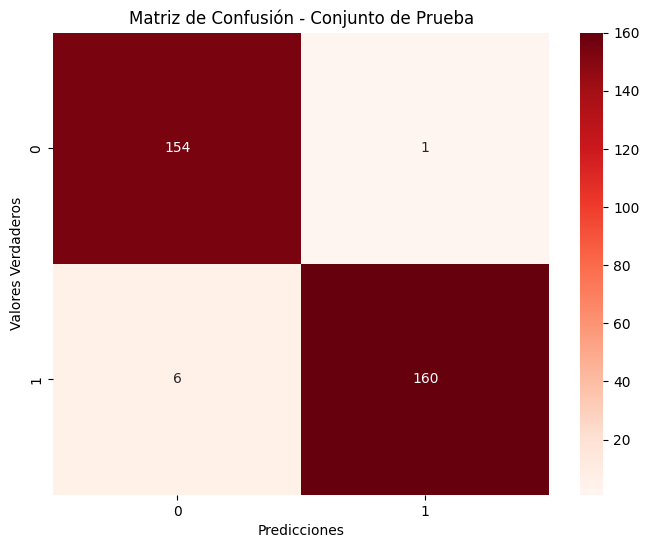

Precisión final: 96.573%


In [253]:
# Crear la matriz de confusión para el conjunto de prueba
cm_test = confusion_matrix(y_test, y_pred_test)

# Crear el mapa de calor para el conjunto de prueba
plt.figure(figsize=(8, 6))
sns.heatmap(cm_test, annot=True, cmap="Reds",fmt='d')
plt.title("Matriz de Confusión - Conjunto de Prueba")
plt.xlabel("Predicciones")
plt.ylabel("Valores Verdaderos")
plt.show()

y_pred_final = dt.predict(Xtest)
dt_precision_final = 100 * accuracy_score(y_test, y_pred_final)
print('Precisión final: {0:.3f}%'.format(dt_precision_final))

In [254]:
# RANDOM FOREST



# Crear el modelo de Random Forest
modelo_rf = RandomForestClassifier(n_estimators=500)
print("Dimensiones entreamiento :", xtrain.shape)
print("Dimensiones prueba ", y_train.shape)

Dimensiones entreamiento : (748, 63)
Dimensiones prueba  (748,)


In [255]:
rf_Model = RandomForestClassifier()
cross_val_scores = cross_val_score(rf_Model, Xtrain, y_train, cv=2)
rf_Model.fit(Xtrain, y_train)
# Evaluar el rendimiento del modelo en los datos de entrenamiento y prueba
train_accuracy = rf_Model.score(Xtrain, y_train) * 100
test_accuracy = rf_Model.score(Xtest, y_test) * 100
print("=======================")
print("Precisión del entrenamiento:", "{:.3f}%".format(train_accuracy))
print("Precisión de prueba:", "{:.3f}%".format(test_accuracy))

Precisión del entrenamiento: 100.000%
Precisión de prueba: 100.000%


In [256]:
# Imprimir los resultados de la validación cruzada
print("=======================")
print("Resultados de la validación cruzada:")
print(cross_val_scores)
print("Precisión media: {:.2f}".format(cross_val_scores.mean()))

Resultados de la validación cruzada:
[0.98930481 0.9973262 ]
Precisión media: 0.99


Prueba con Hiperámetros y feature cuasi-constante

In [257]:
# Crear el modelo de Random Forest
modelo_rf = RandomForestClassifier(n_estimators=100, random_state=42)

print("Dimensiones entreamiento :", xtrain.shape)
print("Dimensiones prueba ", y_train.shape)

Dimensiones entreamiento : (748, 63)
Dimensiones prueba  (748,)


In [258]:
# Número de árboles en el bosque aleatorio
n_estimators = [int(x) for x in np.linspace(start=150, stop=400, num=5)]
# Número de características a considerar en cada división
max_features = ['auto', 'sqrt']
# Número máximo de niveles en el árbol
max_depth = None,
# Número mínimo de muestras requeridas para dividir un nodo
min_samples_split = [2, 4, 6, 8, 10]
# Número mínimo de muestras requeridas en cada nodo hoja
min_samples_leaf = [1, 2, 4, 6, 8, 10]


In [259]:
param_grid = {'n_estimators': n_estimators,
               'max_features': max_features,
               'max_depth': max_depth,
               'min_samples_split': min_samples_split,
               'min_samples_leaf': min_samples_leaf,              
                }
print(param_grid)

{'n_estimators': [150, 212, 275, 337, 400], 'max_features': ['auto', 'sqrt'], 'max_depth': (None,), 'min_samples_split': [2, 4, 6, 8, 10], 'min_samples_leaf': [1, 2, 4, 6, 8, 10]}


In [260]:
rf_Grid = GridSearchCV(estimator = rf_Model, param_grid = param_grid, cv = 5, verbose=2, n_jobs = 4)


In [261]:
rf_Grid.fit(xtrain, y_train)

Fitting 5 folds for each of 300 candidates, totalling 1500 fits


GridSearchCV(cv=5, estimator=RandomForestClassifier(), n_jobs=4,
             param_grid={'max_depth': (None,), 'max_features': ['auto', 'sqrt'],
                         'min_samples_leaf': [1, 2, 4, 6, 8, 10],
                         'min_samples_split': [2, 4, 6, 8, 10],
                         'n_estimators': [150, 212, 275, 337, 400]},
             verbose=2)

In [262]:
rf_Grid.best_params_

{'max_depth': None,
 'max_features': 'sqrt',
 'min_samples_leaf': 1,
 'min_samples_split': 2,
 'n_estimators': 212}

In [263]:
# Evaluar el rendimiento del modelo en los datos de entrenamiento y prueba
train_accuracy = rf_Grid.score(xtrain, y_train) * 100
test_accuracy = rf_Grid.score(xtest, y_test) * 100

In [264]:
print("Precisión del entrenamiento:", "{:.3f}%".format(train_accuracy))
print("Precisión de prueba:", "{:.3f}%".format(test_accuracy))

Precisión del entrenamiento: 100.000%
Precisión de prueba: 99.065%


Prueba con selección de caracteristicas Random FRE

In [265]:
# Contar características seleccionadas
num_selected_features = sum(selected_features)
print("Número de características seleccionadas:", num_selected_features)

Número de características seleccionadas: 31


In [266]:
# Crear el modelo de Random Forest
modelo_rf = RandomForestClassifier(n_estimators=1200)

print("Dimensiones :", xtrainE.shape)
print("Dimensiones ", y_train.shape)

Dimensiones : (748, 31)
Dimensiones  (748,)


In [267]:
# Número de árboles en el bosque aleatorio
n_estimators = [int(x) for x in np.linspace(start=100, stop=150, num=5)]
#Número de características a considerar en cada división
max_features = ['auto', 'sqrt']
# Número máximo de niveles en el árbol
max_depth = None,
# Número mínimo de muestras requeridas para dividir un nodo
min_samples_split = [2, 4, 6, 8, 10]
# Número mínimo de muestras requeridas en cada nodo hoja
min_samples_leaf = [1, 2, 4, 6, 8, 10]

In [268]:
param_grid = {
    'n_estimators': n_estimators,
    'max_features': max_features,
    'max_depth': max_depth,
    'min_samples_split': min_samples_split,
    'min_samples_leaf': min_samples_leaf,
}

print(param_grid)

{'n_estimators': [100, 112, 125, 137, 150], 'max_features': ['auto', 'sqrt'], 'max_depth': (None,), 'min_samples_split': [2, 4, 6, 8, 10], 'min_samples_leaf': [1, 2, 4, 6, 8, 10]}


In [269]:
rf_Grid = GridSearchCV(estimator = rf_Model, param_grid = param_grid, cv = 5, verbose=2, n_jobs = 4)

In [270]:
rf_Grid.fit(xtrainE, y_train)

Fitting 5 folds for each of 300 candidates, totalling 1500 fits


GridSearchCV(cv=5, estimator=RandomForestClassifier(), n_jobs=4,
             param_grid={'max_depth': (None,), 'max_features': ['auto', 'sqrt'],
                         'min_samples_leaf': [1, 2, 4, 6, 8, 10],
                         'min_samples_split': [2, 4, 6, 8, 10],
                         'n_estimators': [100, 112, 125, 137, 150]},
             verbose=2)

In [271]:
rf_Grid.best_params_

{'max_depth': None,
 'max_features': 'sqrt',
 'min_samples_leaf': 1,
 'min_samples_split': 6,
 'n_estimators': 100}

In [272]:
# Evaluar el rendimiento del modelo en los datos de entrenamiento y prueba
train_accuracy = rf_Grid.score(xtrainE, y_train) * 100
test_accuracy = rf_Grid.score(xtestE, y_test) * 100

In [273]:
print("Precisión del entrenamiento:", "{:.3f}%".format(train_accuracy))
print("Precisión de prueba:", "{:.3f}%".format(test_accuracy))

Precisión del entrenamiento: 100.000%
Precisión de prueba: 99.065%


Matriz de confusión prueba adicional

In [274]:
param_sets = [
    {'n_estimators': 100, 'min_samples_split': 15,'min_samples_leaf': 15,'max_depth': 28, 'max_features': 'auto'},
]

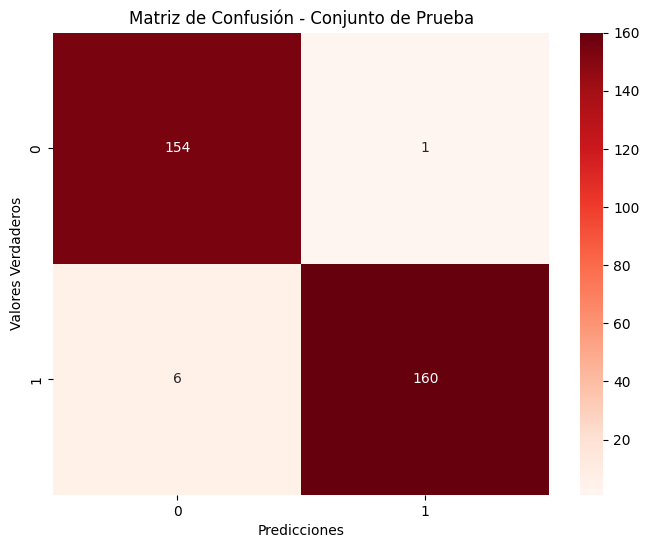

Precisión final: 96.573%


In [275]:
# Crear la matriz de confusión para el conjunto de prueba
cm_test = confusion_matrix(y_test, y_pred_test)

# Crear el mapa de calor para el conjunto de prueba
plt.figure(figsize=(8, 6))
sns.heatmap(cm_test, annot=True, cmap="Reds",fmt='d')
plt.title("Matriz de Confusión - Conjunto de Prueba")
plt.xlabel("Predicciones")
plt.ylabel("Valores Verdaderos")
plt.show()

y_pred_final = dt.predict(Xtest)
dt_precision_final = 100 * accuracy_score(y_test, y_pred_final)
print('Precisión final: {0:.3f}%'.format(dt_precision_final))

Red neuronal

Precisión: 100.000%


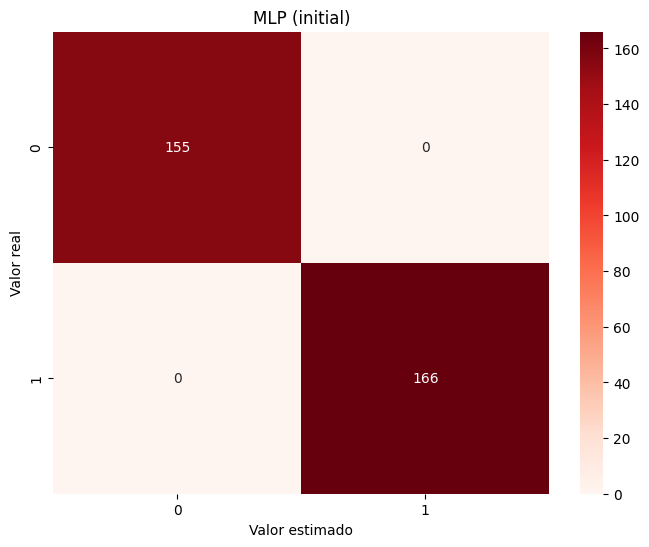

In [276]:
# Modelo con parametros de prueba

clf = MLPClassifier(hidden_layer_sizes = (50,50), alpha=0.01, max_iter=1000) 
clf.fit(Xtrain, y_train)
y_pred = clf.predict(Xtest)
y_prob = clf.predict_proba(Xtest)

cm = confusion_matrix(y_test, y_pred)
cm_df = pd.DataFrame(cm)

mlp_precision = 100 * accuracy_score(y_test, y_pred)
print('Precisión: {0:.3f}%'.format(mlp_precision))

plt.figure(figsize=(8, 6))
sns.heatmap(cm_df,cmap="Reds", annot=True, fmt='d')
plt.title('MLP (initial)')
plt.ylabel('Valor real')
plt.xlabel('Valor estimado')
plt.show()

Ahora vamos a ajustar los parametros con el GridSearch

In [278]:
param_grid = [{'hidden_layer_sizes' : [(10,10), (20,20,10)], 'max_iter':[20, 50, 100, 500, 1000]}, 
              {'alpha': [0.0001, 0.001, 0.01, 0.1]}]

In [279]:
model = MLPClassifier()
grid_search = GridSearchCV(model, param_grid, cv=5, scoring='accuracy')
grid_search.fit(Xtrain, y_train)

GridSearchCV(cv=5, estimator=MLPClassifier(),
             param_grid=[{'hidden_layer_sizes': [(10, 10), (20, 20, 10)],
                          'max_iter': [20, 50, 100, 500, 1000]},
                         {'alpha': [0.0001, 0.001, 0.01, 0.1]}],
             scoring='accuracy')

In [280]:
grid_search.best_params_

{'hidden_layer_sizes': (10, 10), 'max_iter': 100}

{'en': 0, 'nl': 1}
Precisión de entrenamiento: 100.000%
Precisión de prueba: 99.688%
Tiempo de ejecución: 2.320 segundos


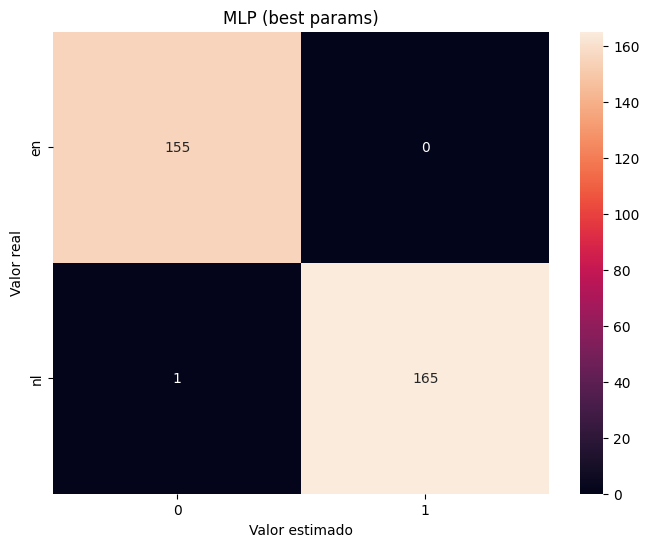

In [281]:
import time
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.preprocessing import LabelEncoder
from sklearn.neural_network import MLPClassifier
from sklearn.metrics import confusion_matrix

start_time = time.time()

le = LabelEncoder()

# Ajustar el LabelEncoder a los datos de entrenamiento
le.fit(y_train)

clf = MLPClassifier(hidden_layer_sizes=(3000), max_iter=60)
clf.fit(xtrain, y_train)

y_pred = clf.predict(xtest)
y_prob = clf.predict_proba(xtest)

mapping = dict(zip(le.classes_, range(0, len(le.classes_))))
print(mapping)

cm = confusion_matrix(y_test, y_pred)
cm_df = pd.DataFrame(cm, index=mapping)

train_accuracy = clf.score(xtrain, y_train) * 100
test_accuracy = clf.score(xtest, y_test) * 100

end_time = time.time()
elapsed_time = end_time - start_time

print("Precisión de entrenamiento: {:.3f}%".format(train_accuracy))
print("Precisión de prueba: {:.3f}%".format(test_accuracy))
print("Tiempo de ejecución: {:.3f} segundos".format(elapsed_time))

plt.figure(figsize=(8, 6))
sns.heatmap(cm_df, annot=True ,fmt='d')
plt.title('MLP (best params)')
plt.ylabel('Valor real')
plt.xlabel('Valor estimado')
plt.show()
